In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
import warnings
from collections.abc import Sequence
import windowCNV as wcnv
import infercnvpy
warnings.simplefilter("ignore")

sc.settings.set_figure_params(figsize=(5, 5))

/Users/ceceliazhang/miniconda3/envs/windowcnv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import gzip
import anndata as ad
import seaborn as sns

# ========== FILE PATHS ==========
data_dir = "/Users/ceceliazhang/Desktop/JHU/SP25/Computational_Stem_Cell_Biology/Final_Project_CNV/"
tnbc_file = os.path.join(data_dir, "GSM4476486_combined_UMIcount_CellTypes_TNBC1.txt.gz")

# ========== DATA LOADING AND PROCESSING ==========
def load_tnbc_data(file_path):
    """Load TNBC data and separate CNV labels from gene expression data."""
    with gzip.open(file_path, 'rt') as f:
        # Read the first two rows (metadata) separately
        metadata = pd.read_csv(f, sep='\t', nrows=2, index_col=0)
        # Read the remaining gene expression data
        f.seek(0)  # Reset file pointer
        data = pd.read_csv(f, sep='\t', skiprows=2, index_col=0)
    
    print(f"Loaded {file_path} with shape: {data.shape}")
    print(f"Metadata shape: {metadata.shape}")
    print(f"First 5 rows of gene expression data:\n{data.iloc[:5, :5]}")
    print(f"First 5 rows of metadata:\n{metadata.iloc[:, :5]}")
    
    return data, metadata

print("Loading TNBC data...")
gene_data, metadata = load_tnbc_data(tnbc_file)

# ========== DATA STRUCTURE INSPECTION ==========
print("\nData Types of Metadata:")
print(metadata.dtypes)

print("\nUnique CNV Labels in 'copykat.pred':")
print(metadata.loc['copykat.pred'].unique())

print("\nUnique Cluster Labels in 'cluster.pred':")
print(metadata.loc['cluster.pred'].unique())

# ========== CREATING ANNDATA OBJECT ==========
print("\nCreating AnnData object...")
adata = ad.AnnData(X=gene_data.T.values)

# Assign metadata as cell-level annotations
adata.obs['copykat_pred'] = metadata.loc['copykat.pred'].values
adata.obs['cluster_pred'] = metadata.loc['cluster.pred'].values
adata.obs_names = gene_data.columns  # Cell barcodes
adata.var_names = gene_data.index    # Gene names

# Check structure
print(f"AnnData object shape: {adata.shape}")
print(f"Observations (obs):\n{adata.obs.head()}")
print(f"Variables (var):\n{adata.var.head()}")

# ========== BASIC QC AND FILTERING ==========
print("\nApplying basic filtering...")
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_cells(adata, max_counts=30000)
sc.pp.filter_genes(adata, min_cells=3)

print(f"After filtering: {adata.shape}")

# ========== LOG NORMALIZATION ==========
print("\nLog-normalizing data...")
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['lognorm'] = adata.X.copy()

# ========== HIGHLY VARIABLE GENES SELECTION ==========
print("\nIdentifying highly variable genes...")
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=6, min_disp=0.25)

# Check number of highly variable genes
num_hvg = adata.var['highly_variable'].sum()
print(f"Number of highly variable genes: {num_hvg}")

# ========== SAVE PROCESSED DATA ==========
output_file = os.path.join(data_dir, "TNBC1_processed.h5ad")
print(f"\nSaving processed data to {output_file}...")
adata.write(output_file)

print("\nData processing complete.")


Loading TNBC data...
Loaded /Users/ceceliazhang/Desktop/JHU/SP25/Computational_Stem_Cell_Biology/Final_Project_CNV/GSM4476486_combined_UMIcount_CellTypes_TNBC1.txt.gz with shape: (33694, 1097)
Metadata shape: (2, 1097)
First 5 rows of gene expression data:
              T  N  T.1  T.2  T.3
cluster.pred                     
RP11-34P13.3  0  0    0    0    0
FAM138A       0  0    0    0    0
OR4F5         0  0    0    0    0
RP11-34P13.7  0  0    0    0    0
RP11-34P13.8  0  0    0    0    0
First 5 rows of metadata:
             AAACCTGCACCTTGTC AAACGGGAGTCCTCCT AAACGGGTCCAGAGGA  \
copykat.pred                T                N                T   
cluster.pred                T                N                T   

             AAAGATGCAGTTTACG AAAGCAACAGGAATGC  
copykat.pred                T                T  
cluster.pred                T                T  

Data Types of Metadata:
AAACCTGCACCTTGTC    object
AAACGGGAGTCCTCCT    object
AAACGGGTCCAGAGGA    object
AAAGATGCAGTTTACG    obje

Loading processed data...
Filtering to keep only highly variable genes...
AnnData object shape after HVG filtering: (840, 3453)
AnnData object shape: (840, 3453)
Observations (obs):
    copykat_pred cluster_pred  n_genes  n_counts
T              T            T     3590     13976
N              N            N     2629      8732
T.1            T            T     4166     17138
T.2            T            T     1703      9519
T.3            T            T     2778     10285
Variables (var):
              n_cells  highly_variable     means  dispersions  \
cluster.pred                                                    
SAMD11             16             True  0.016239     0.133897   
HES4              336             True  0.452177     0.943018   
ISG15             510             True  1.301078     3.654954   
AGRN              229             True  0.227251     0.363050   
RNF223             41             True  0.035531     0.083448   

              dispersions_norm  
cluster.pred      

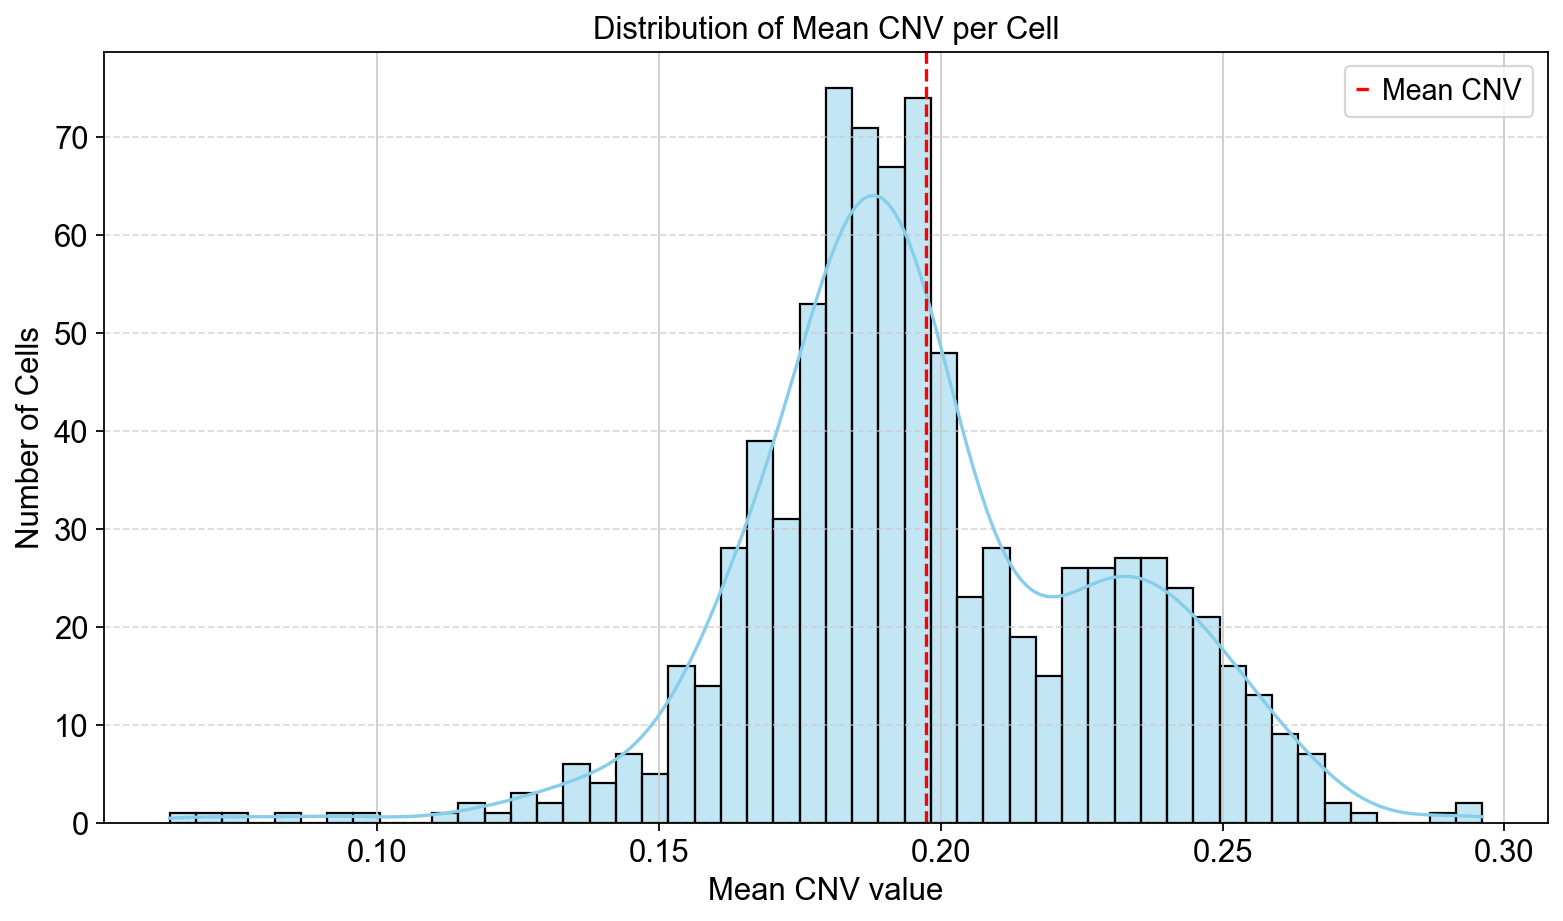


Saving updated data to /Users/ceceliazhang/Desktop/JHU/SP25/Computational_Stem_Cell_Biology/Final_Project_CNV/TNBC1_processed_with_cnv.h5ad...

Data processing and plotting complete.


In [3]:
import os
import anndata as ad
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ========== FILE PATHS ==========
data_dir = "/Users/ceceliazhang/Desktop/JHU/SP25/Computational_Stem_Cell_Biology/Final_Project_CNV/"
processed_file = os.path.join(data_dir, "TNBC1_processed.h5ad")

# ========== LOAD PROCESSED DATA ==========
print("Loading processed data...")
adata = ad.read_h5ad(processed_file)

# ========== FILTERING HIGHLY VARIABLE GENES ==========
print("Filtering to keep only highly variable genes...")
adata = adata[:, adata.var['highly_variable']].copy()
print(f"AnnData object shape after HVG filtering: {adata.shape}")

# Check data structure
print(f"AnnData object shape: {adata.shape}")
print(f"Observations (obs):\n{adata.obs.head()}")
print(f"Variables (var):\n{adata.var.head()}")

# ========== CHECK FOR CNV LABELS ==========
print("\nUnique CNV Labels in 'copykat_pred':", adata.obs['copykat_pred'].unique())
print("Unique Cluster Labels in 'cluster_pred':", adata.obs['cluster_pred'].unique())

# ========== ANALYSIS AND PLOTTING ==========
# Calculate mean CNV per cell
print("\nCalculating mean CNV per cell...")
adata.obs['mean_cnv'] = adata.X.mean(axis=1)

# Plot histogram of mean CNV per cell
plt.figure(figsize=(10, 6))
sns.histplot(adata.obs['mean_cnv'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Mean CNV per Cell")
plt.xlabel("Mean CNV value")
plt.ylabel("Number of Cells")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axvline(adata.obs['mean_cnv'].mean(), color='red', linestyle='--', linewidth=1.5, label='Mean CNV')
plt.legend()
plt.tight_layout()
plt.show()

# ========== SAVE UPDATED ANNDATA OBJECT ==========
output_file = os.path.join(data_dir, "TNBC1_processed_with_cnv.h5ad")
print(f"\nSaving updated data to {output_file}...")
adata.write(output_file)

print("\nData processing and plotting complete.")


In [4]:
import os
import pandas as pd
import anndata as ad
import scanpy as sc

# File paths
data_dir = "/Users/ceceliazhang/Desktop/JHU/SP25/Computational_Stem_Cell_Biology/Final_Project_CNV/"
processed_file = os.path.join(data_dir, "TNBC1_processed_with_cnv.h5ad")
gtf_file = os.path.join(data_dir, "gencode.v39.annotation.gtf")

# Load processed data
print("Loading processed data...")
adata = ad.read_h5ad(processed_file)
print(f"Data shape before annotation: {adata.shape}")

# ========================
# 1. Extract Gene Information from GTF File
# ========================
print("Extracting gene information from GTF file...")
gene_info = []

with open(gtf_file, 'r') as file:
    for line in file:
        if line.startswith("#"):
            continue
        fields = line.strip().split('\t')
        if fields[2] == "gene":
            chrom = fields[0]
            start = int(fields[3])
            end = int(fields[4])
            attributes = fields[8].split(';')
            
            gene_name = ""
            for attr in attributes:
                attr = attr.strip()
                if attr.startswith("gene_name"):
                    gene_name = attr.split(' ')[1].replace('"', '')
                    break

            if gene_name:
                gene_info.append([gene_name, chrom, start, end])

# Create DataFrame and remove duplicates
gtf_df = pd.DataFrame(gene_info, columns=['gene_name', 'chromosome', 'start', 'end'])
gtf_df.drop_duplicates(subset='gene_name', inplace=True)
print(f"GTF DataFrame shape after removing duplicates: {gtf_df.shape}")
print(gtf_df.head())

# ========================
# 2. Check for Missing Genes
# ========================
adata_genes = set(adata.var_names)
gtf_genes = set(gtf_df['gene_name'])

missing_genes = adata_genes - gtf_genes
print(f"Number of genes in AnnData not found in GTF: {len(missing_genes)}")

# ========================
# 3. Merge GTF Data with AnnData Object
# ========================
print("Merging GTF data with AnnData object...")

# Ensure gene names are in a column, not in the index
adata.var['gene_symbol'] = adata.var_names

# Merge without expanding rows
merged_df = adata.var.merge(gtf_df, left_on='gene_symbol', right_on='gene_name', how='left')

# Drop unnecessary columns and reset index
merged_df.drop(columns=['gene_name'], inplace=True)
merged_df.set_index('gene_symbol', inplace=True)

# Ensure consistency in shape
if merged_df.shape[0] != adata.shape[1]:
    print("Warning: The number of genes in the merged DataFrame does not match the AnnData object.")

# Assign back to AnnData
adata.var = merged_df

print(f"Updated .var structure:\n{adata.var.head()}")

# ========================
# 4. Save the Updated AnnData Object
# ========================
output_file = os.path.join(data_dir, "TNBC1_annotated.h5ad")
print(f"Saving annotated data to {output_file}...")
adata.write(output_file)

print("\nData annotation and saving complete.")


Loading processed data...
Data shape before annotation: (840, 3453)
Extracting gene information from GTF file...
GTF DataFrame shape after removing duplicates: (60286, 4)
     gene_name chromosome  start    end
0      DDX11L1       chr1  11869  14409
1       WASH7P       chr1  14404  29570
2    MIR6859-1       chr1  17369  17436
3  MIR1302-2HG       chr1  29554  31109
4    MIR1302-2       chr1  30366  30503
Number of genes in AnnData not found in GTF: 246
Merging GTF data with AnnData object...
Updated .var structure:
             n_cells  highly_variable     means  dispersions  \
gene_symbol                                                    
SAMD11            16             True  0.016239     0.133897   
HES4             336             True  0.452177     0.943018   
ISG15            510             True  1.301078     3.654954   
AGRN             229             True  0.227251     0.363050   
RNF223            41             True  0.035531     0.083448   

             dispersions_no


Proceeding with PCA and clustering...
Cancerous Cells: 2/2 markers found
CD4+ T cells: 2/2 markers found
Activated T cells: 3/3 markers found
HLA-DR+ Cells: 2/2 markers found
categories: 0, 1, 2, etc.
var_group_labels: Cancerous Cells, CD4+ T cells, Activated T cells, etc.


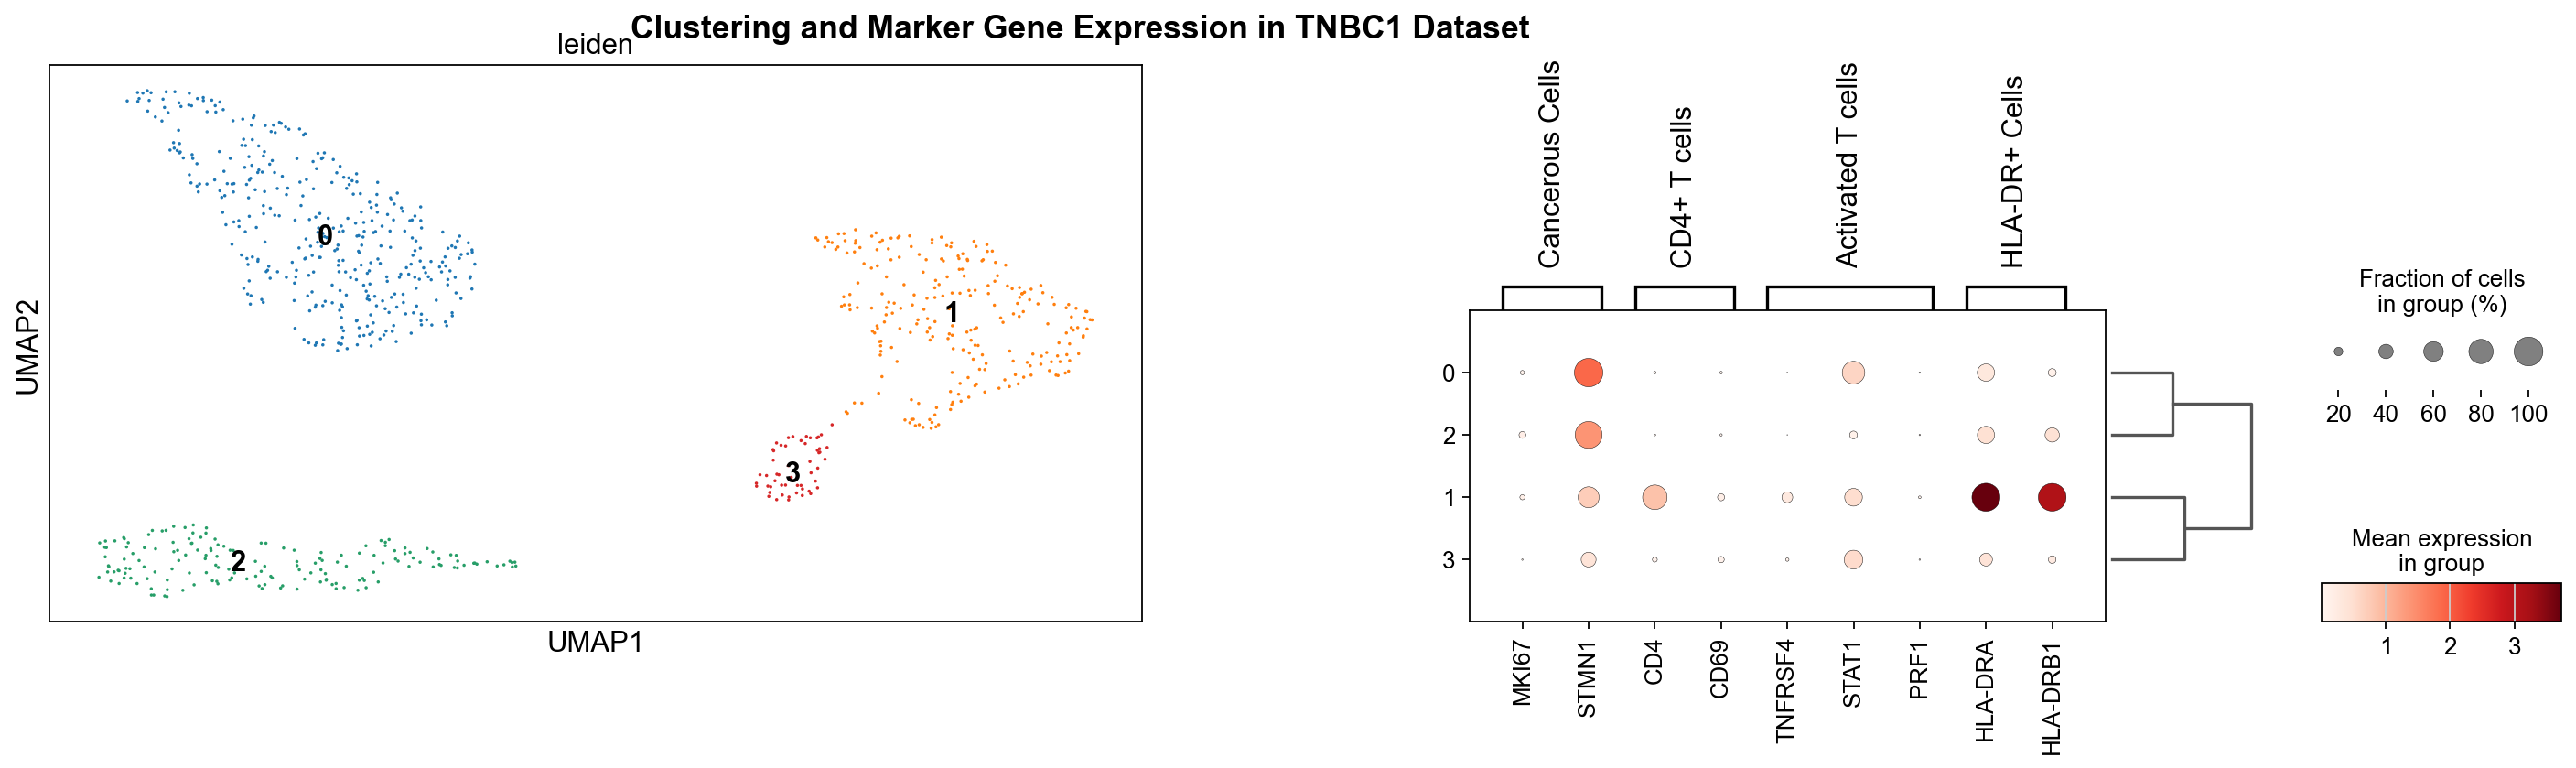

In [5]:
import matplotlib.pyplot as plt
import scanpy as sc

# Step 1: PCA and Clustering
print("\nProceeding with PCA and clustering...")
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=5)
sc.tl.leiden(adata, resolution=0.1)

# UMAP
sc.tl.umap(adata)
sc.tl.dendrogram(adata, groupby="leiden")

# Step 2: Define marker genes
marker_genes_dict = {
    "Cancerous Cells": ["MKI67", "STMN1"],
    "CD4+ T cells": ["CD4", "CD69"],
    "Activated T cells": ["TNFRSF4", "STAT1", "PRF1"],
    "HLA-DR+ Cells": ["HLA-DRA", "HLA-DRB1"]
}

# Check the presence of marker genes in the dataset
for key, genes in marker_genes_dict.items():
    found_genes = [gene for gene in genes if gene in adata.var_names]
    print(f"{key}: {len(found_genes)}/{len(genes)} markers found")

# Step 3: Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 5), gridspec_kw={'wspace': 0.3})

# UMAP plot with Leiden clusters
sc.pl.umap(adata, color='leiden', ax=ax1, s=10, legend_loc='on data', show=False)

# Dotplot for marker genes (using index directly for gene names)
sc.pl.dotplot(
    adata,
    marker_genes_dict,
    groupby='leiden',
    ax=ax2,
    dendrogram=True,
    show=False
)

plt.suptitle("Clustering and Marker Gene Expression in TNBC1 Dataset", fontsize=16, fontweight='bold')
plt.show()


cell_type
Cancerous Cells      375
Activated T cells    241
CD4+ T cells         171
HLA-DR+ cells         53
Name: count, dtype: int64

Top 5 lowest-variance cell types:

Cancerous Cells: avg variance = 0.0783
CD4+ T cells: avg variance = 0.0894
Activated T cells: avg variance = 0.1216
HLA-DR+ cells: avg variance = 0.1269


Running inferCNV chunks: 100%|██████████████████████| 1/1 [00:00<00:00,  9.48it/s]


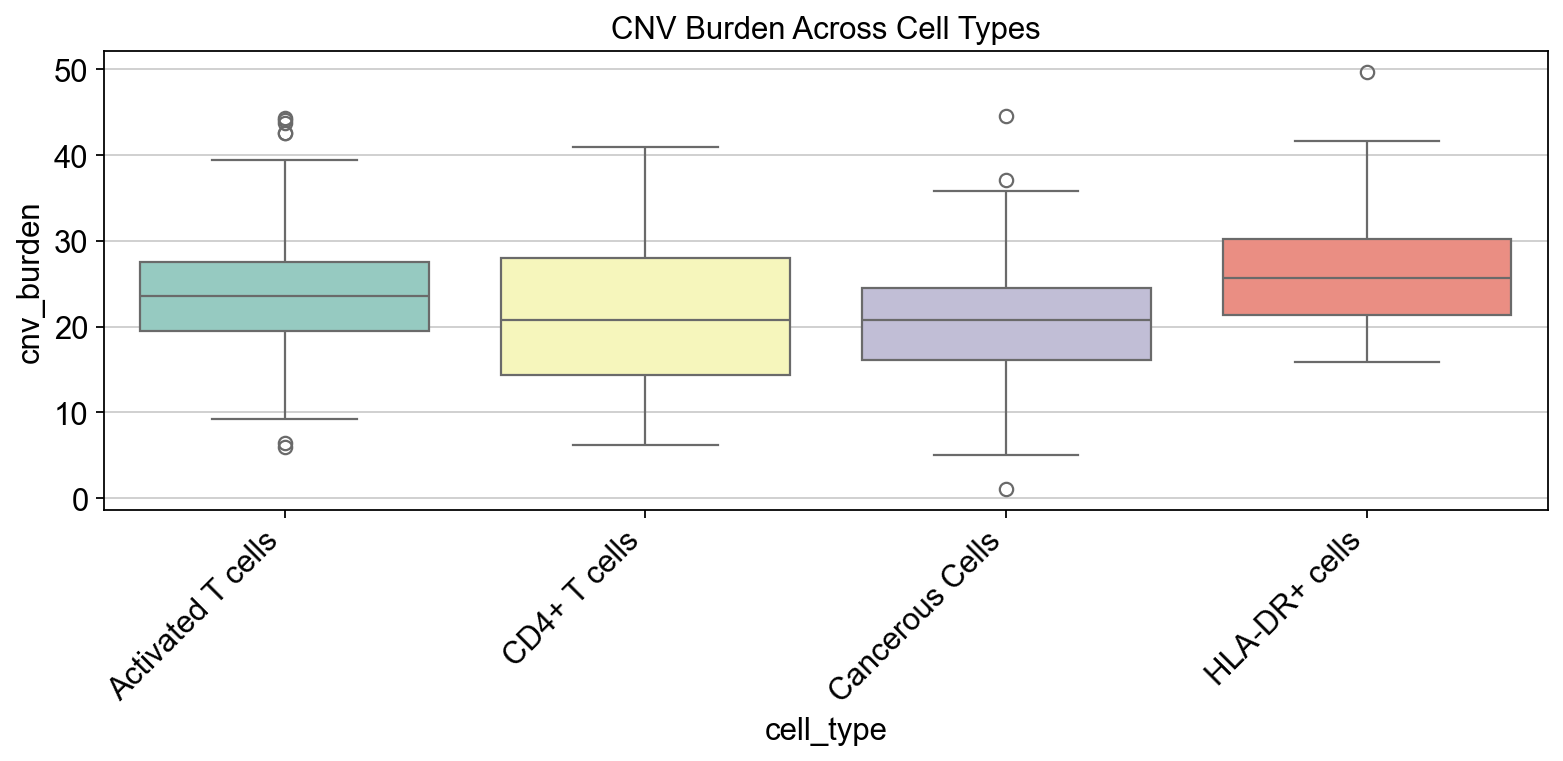

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import scanpy as sc

# Assign clustering labels based on the dot plot
cluster_labels = {
    "Cancerous Cells": [0],
    "CD4+ T cells": [2],
    "Activated T cells": [1],
    "HLA-DR+ cells": [3],
}

# Column name for new annotations
new_obs_name = 'cell_type'

# Ensure leiden column is integer type
adata.obs["leiden"] = adata.obs["leiden"].astype(int)

# Initialize new column with NaN values
adata.obs[new_obs_name] = np.nan

# Assign clusters based on the dot plot interpretation
for cell_type, cluster_ids in cluster_labels.items():
    ind = adata.obs["leiden"].isin(cluster_ids)
    adata.obs.loc[ind, new_obs_name] = cell_type

# Convert to categorical type
adata.obs[new_obs_name] = adata.obs[new_obs_name].astype("category")
print(adata.obs[new_obs_name].value_counts())

# ==============================================================
# CNV Analysis
# ==============================================================

# Finding reference candidates
wcnv.find_reference_candidates(adata)

# Infer CNV
wcnv.infercnv(
    adata,
    reference_key='cell_type',
    reference_cat='Cancerous Cells', 
    normalization_mode='reference',
    lfc_clip=3,
    window_distance=5e6,
    min_genes_per_window=5,
    smooth=True,
    dynamic_threshold=1.5,
    exclude_chromosomes=("chrX", "chrY"),
    chunksize=5000,
    n_jobs=4,
    inplace=True,
    layer='counts',
    key_added='cnv',
    calculate_gene_values=False
)

# Extract inferred CNV matrix
X_cnv = adata.obsm['X_cnv'].copy()

# Convert sparse matrix to dense
X_cnv = X_cnv.toarray()
cnv_df = pd.DataFrame(X_cnv, index=adata.obs_names)

# Extract chromosome positions
chr_pos = adata.uns['cnv']['chr_pos']
sorted_chr_pos = sorted(chr_pos.items(), key=lambda x: x[1])

# Assign chromosome labels to bins
window_chromosomes = []
for i, (chrom, start_idx) in enumerate(sorted_chr_pos):
    end_idx = sorted_chr_pos[i + 1][1] if i + 1 < len(sorted_chr_pos) else X_cnv.shape[1]
    window_chromosomes.extend([chrom] * (end_idx - start_idx))

assert len(window_chromosomes) == cnv_df.shape[1]

# Label columns by chromosome
cnv_df.columns = [f"{chrom}_bin{i}" for i, chrom in enumerate(window_chromosomes)]

# Calculate CNV burden as sum of absolute CNV signal per cell
adata.obs["cnv_burden"] = cnv_df.abs().sum(axis=1)

# ==============================================================
# Visualization of CNV Burden
# ==============================================================

plt.figure(figsize=(10, 5))
sns.boxplot(data=adata.obs, x="cell_type", y="cnv_burden", palette="Set3")
plt.xticks(rotation=45, ha='right')
plt.title("CNV Burden Across Cell Types")
plt.tight_layout()
plt.show()


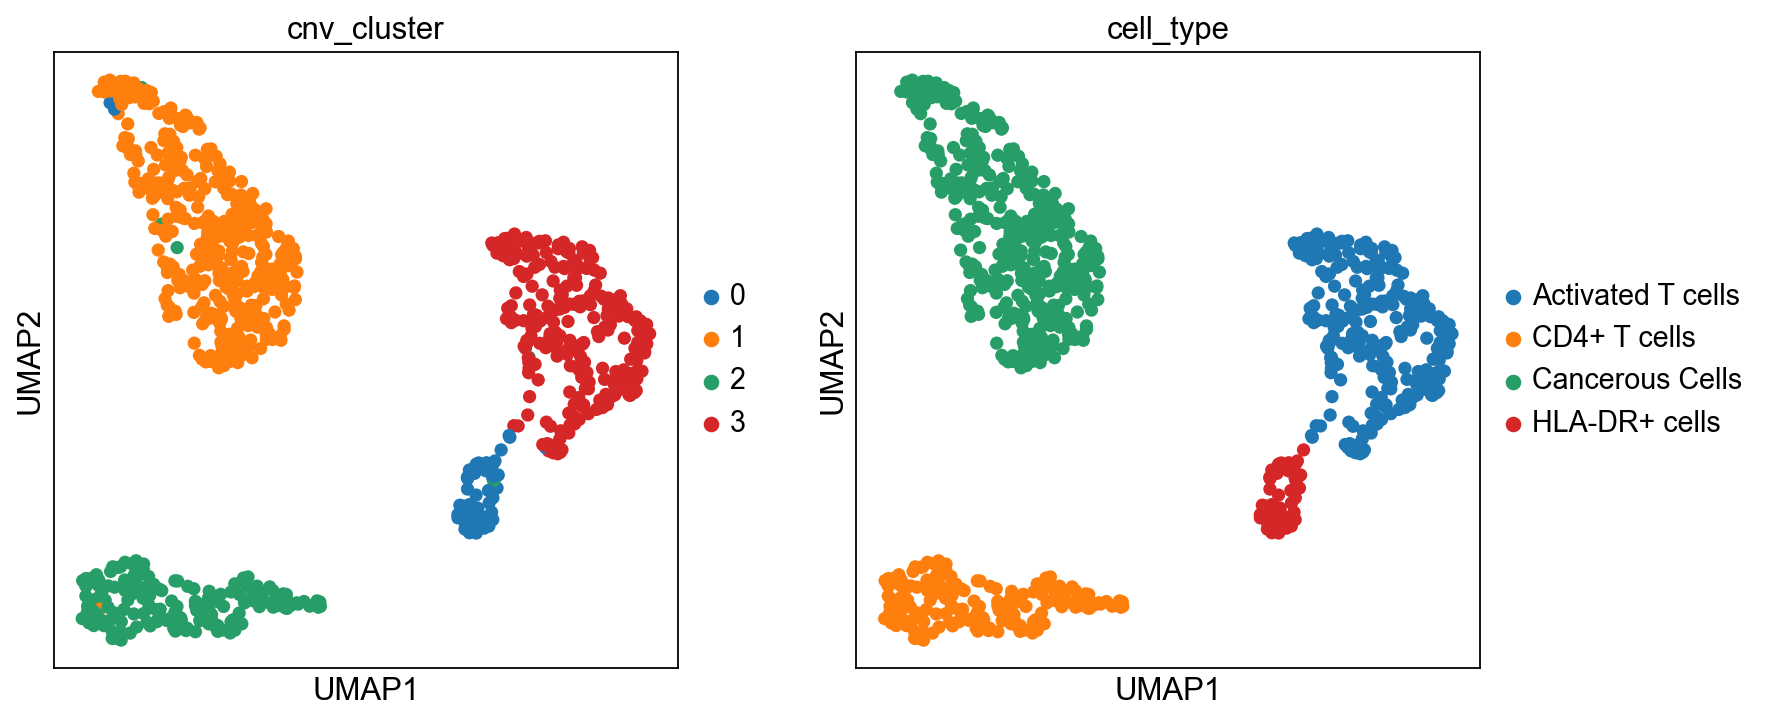

In [7]:
# ==============================================================
# Dimensionality Reduction and Clustering
# ==============================================================

# PCA for dimensionality reduction
pca = PCA(n_components=10)
cnv_pca = pca.fit_transform(cnv_df)

# Cluster cells using KMeans
kmeans = KMeans(n_clusters=4, random_state=0)
adata.obs["cnv_cluster"] = kmeans.fit_predict(cnv_pca).astype(str)

# Visualize clusters on UMAP
sc.pl.umap(adata, color=["cnv_cluster", "cell_type"])

[INFO] Gain threshold: > 0.6037
[INFO] Loss threshold: < -0.5304
Assigning CNAs using all cores...


Parallel CNA assignment: 100%|█████████████████| 840/840 [00:02<00:00, 403.18it/s]


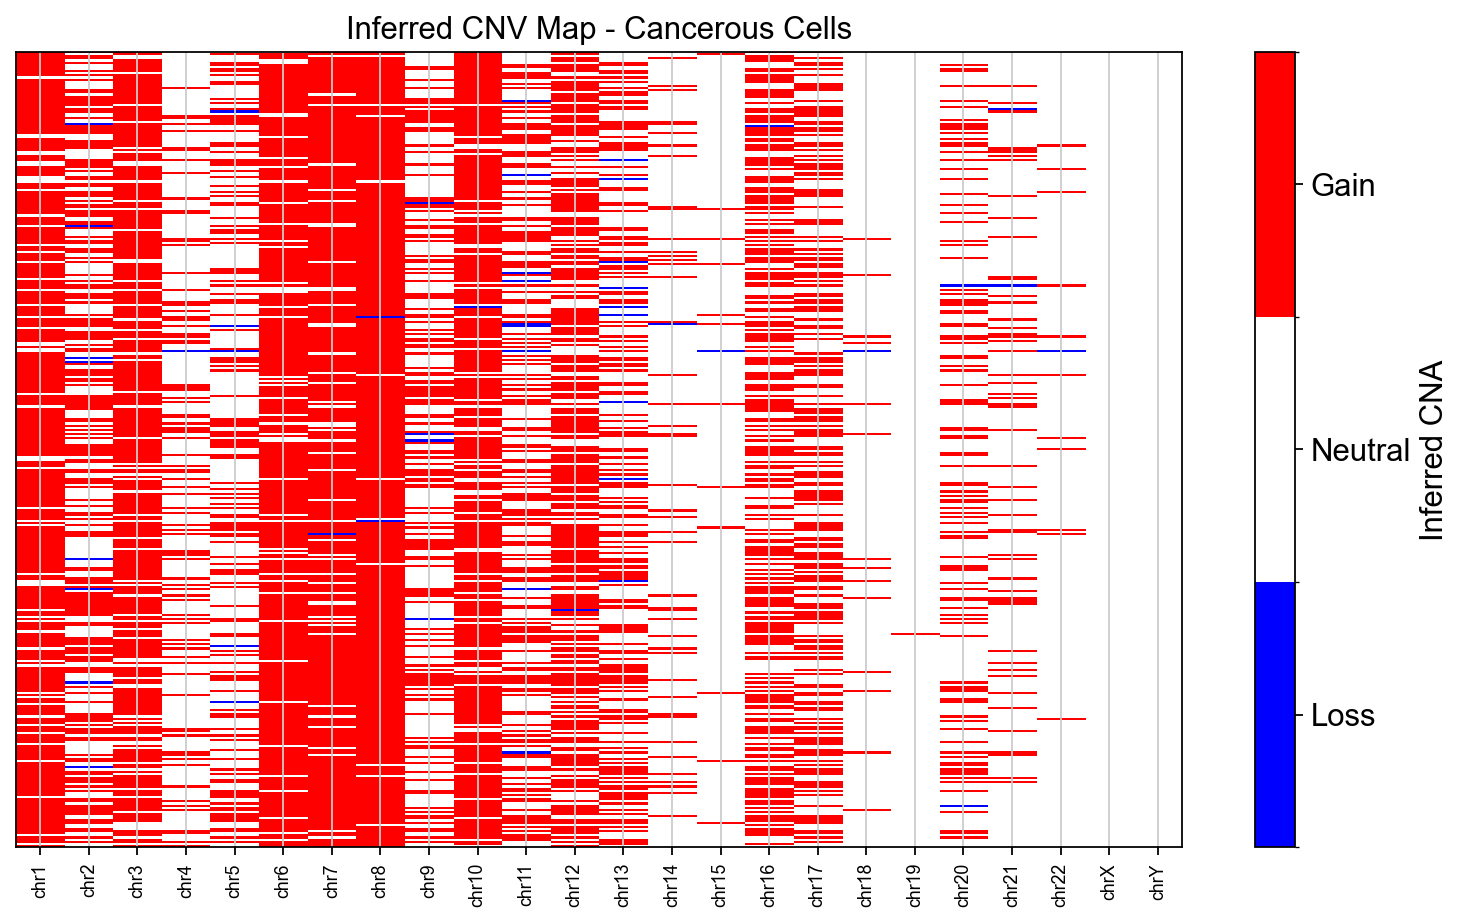

In [8]:

# ==============================================================
# Assign CNAs and Evaluate
# ==============================================================

wcnv.assign_cnas_to_cells_parallel(adata, gain_percentile=60, loss_percentile=60)
wcnv.plot_inferred_cnv_map(adata, cell_type="Cancerous Cells")

[INFO] Gain threshold: > 0.7744
[INFO] Loss threshold: < -0.5763


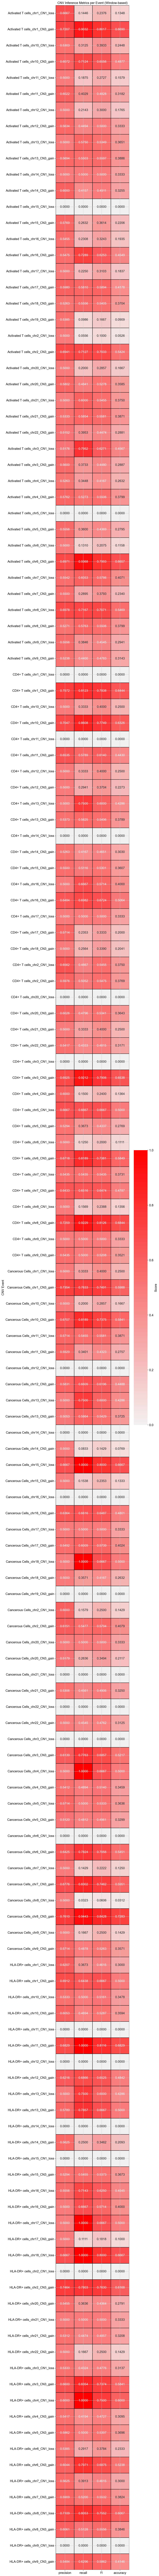

[INFO] Total predicted CNVs: 16407


(             cell_type chromosome CN groundtruth   TP   FP   FN  precision  \
 0    Activated T cells       chr1  1        loss   24   12  142   0.666667   
 1    Activated T cells       chr1  3        gain  485  188   52   0.720654   
 2    Activated T cells      chr10  1        loss   35   31   77   0.530303   
 3    Activated T cells      chr10  3        gain  218  141   88   0.607242   
 4    Activated T cells      chr11  1        loss    3    3   13   0.500000   
 ..                 ...        ... ..         ...  ...  ...  ...        ...   
 154      HLA-DR+ cells       chr7  3        gain   26   18   24   0.590909   
 155      HLA-DR+ cells       chr8  1        loss   91   37   22   0.710938   
 156      HLA-DR+ cells       chr8  3        gain   20   13   19   0.606061   
 157      HLA-DR+ cells       chr9  1        loss    0    0    3   0.000000   
 158      HLA-DR+ cells       chr9  3        gain   17   14   10   0.548387   
 
        recall        f1  accuracy  n_events  
 0 

In [9]:
# Formatting CNV calls
def format_called_cnas(cna_list):
    if not cna_list or not isinstance(cna_list, list):
        return ""
    formatted = []
    for chrom, start, end, event in cna_list:
        cn = "3" if event == "gain" else "1"
        formatted.append(f"{chrom.replace('chr', '')}:{start}-{end} (CN {cn})")
    return "; ".join(formatted)

# Apply formatting function to 'called_cnas' column
adata.obs["simulated_cnvs"] = adata.obs["called_cnas"].apply(format_called_cnas)

# Evaluate CNV calls with defined thresholds
wcnv.evaluate_cnv_with_window(adata, gain_percentile=30, loss_percentile=40)


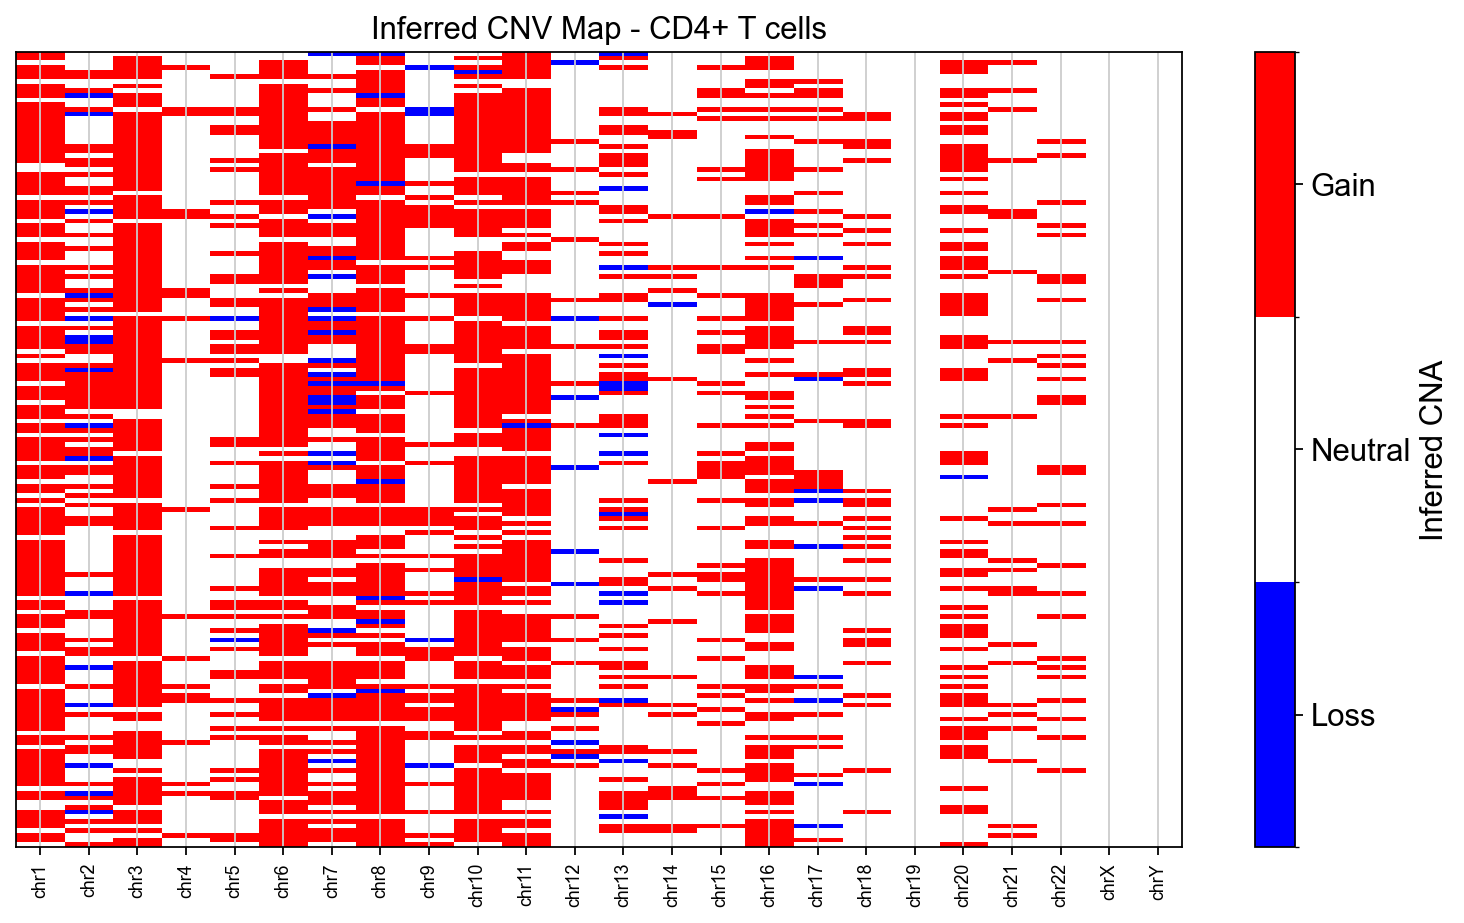

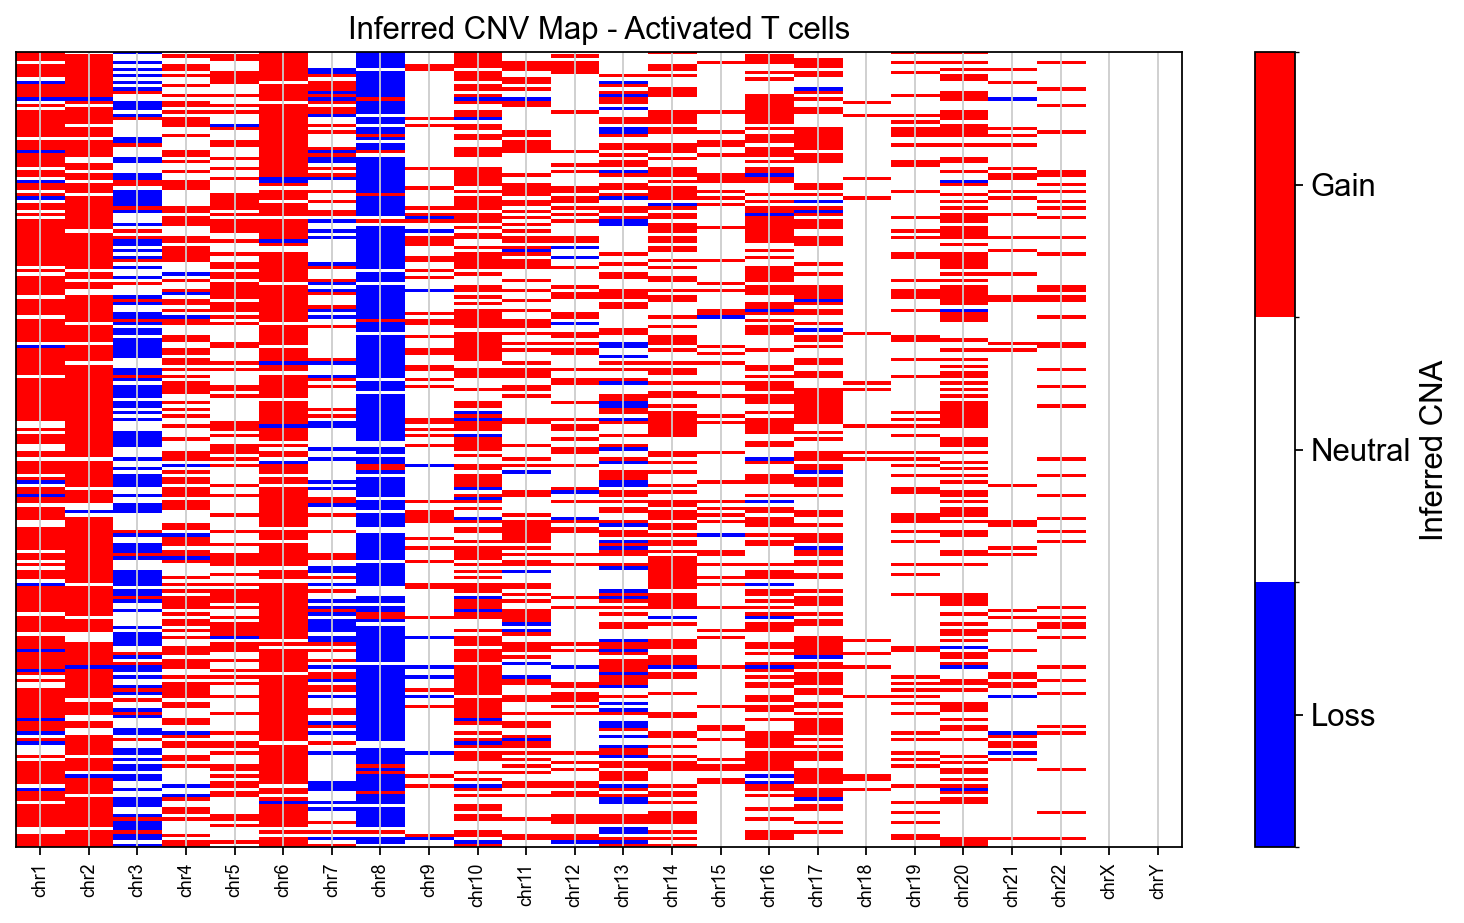

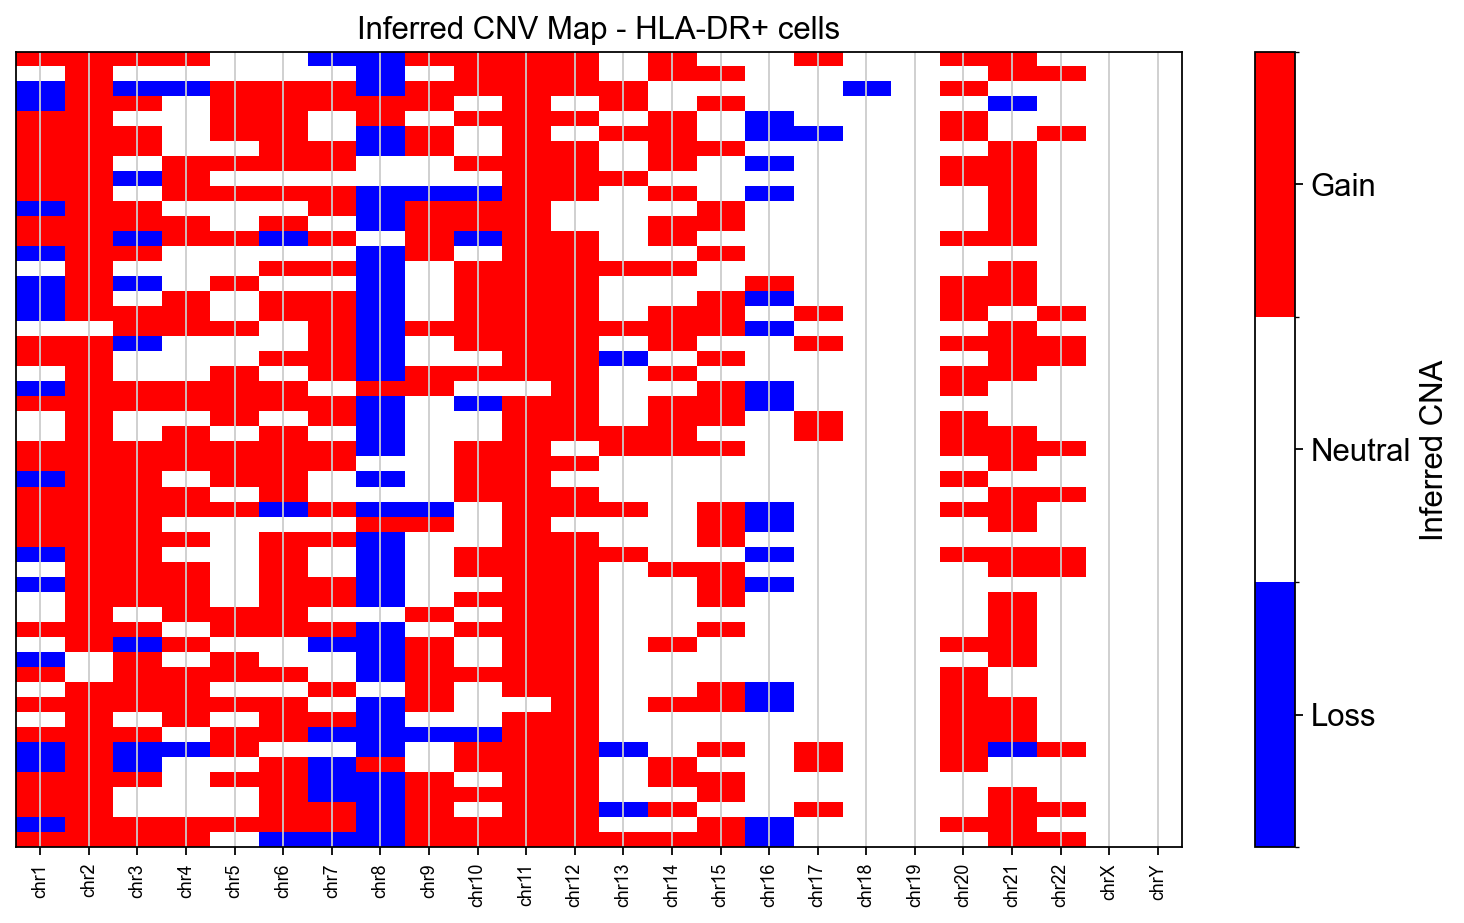

In [10]:
# Plotting inferred CNV map for CD4+ T cells
wcnv.plot_inferred_cnv_map(adata, cell_type="CD4+ T cells")

# Plotting inferred CNV map for Activated T cells
wcnv.plot_inferred_cnv_map(adata, cell_type="Activated T cells")

# Plotting inferred CNV map for Activated T cells
wcnv.plot_inferred_cnv_map(adata, cell_type="HLA-DR+ cells")


Confusion Matrix:
 [[541  10]
 [  0 289]]

Classification Report:
               precision    recall  f1-score   support

           T       0.97      1.00      0.98       289
           N       1.00      0.98      0.99       551

    accuracy                           0.99       840
   macro avg       0.98      0.99      0.99       840
weighted avg       0.99      0.99      0.99       840



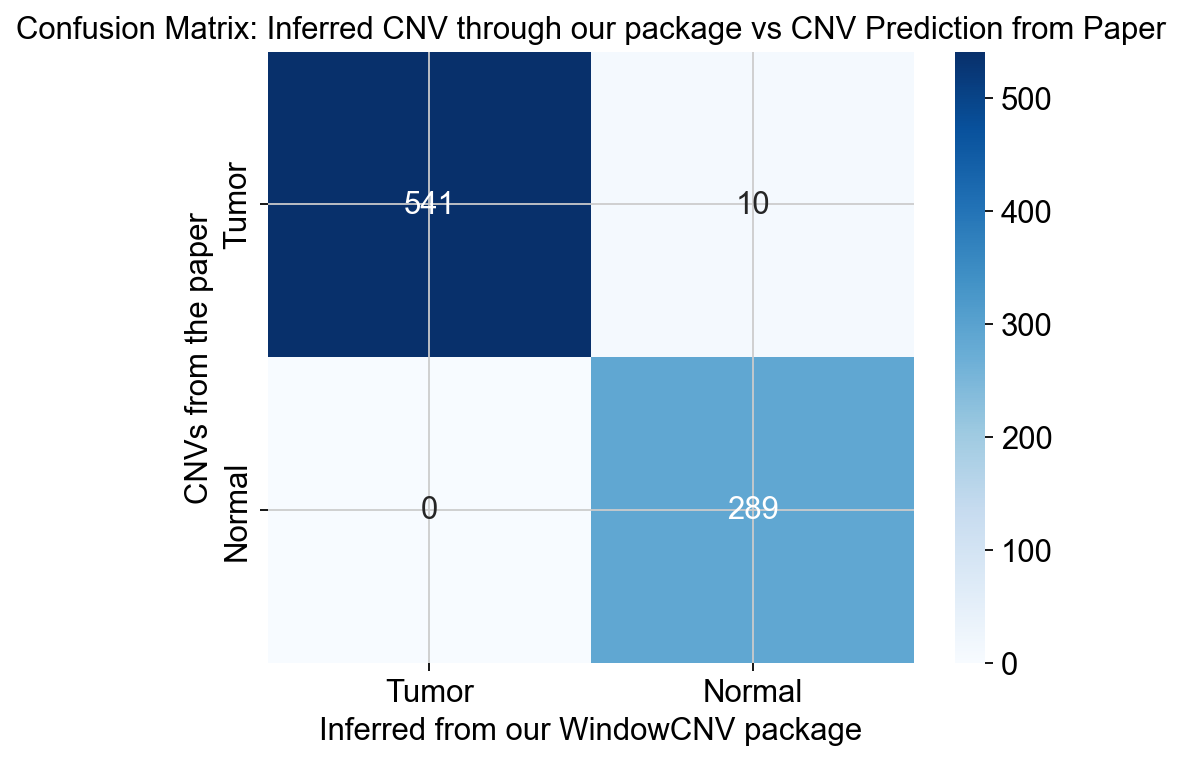

In [79]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================
# Infer Clusters Using K-Means (2 Clusters: Tumor/Normal)
# ==============================================================

# Reduce dimensionality using PCA
pca = PCA(n_components=10)
cnv_pca = pca.fit_transform(cnv_df)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=0)
adata.obs["cnv_group"] = kmeans.fit_predict(cnv_pca).astype(str)

# Determine which cluster is "Tumor" and which is "Normal"
centroid_means = kmeans.cluster_centers_.mean(axis=1)

# Assign labels based on centroid means
if centroid_means[0] > centroid_means[1]:
    mapping = {"0": "T", "1": "N"}
else:
    mapping = {"0": "N", "1": "T"}

# Apply mapping
adata.obs["cnv_group"] = adata.obs["cnv_group"].replace(mapping)

# ==============================================================
# Comparison with Ground Truth
# ==============================================================

# Correct ground truth column name
ground_truth_col = "copykat_pred"  # Ensure this column exists

# Ensure alignment of cell IDs between ground truth and inferred labels
common_cells = adata.obs_names.intersection(adata.obs.index)

# Check for missing values in the ground truth column
if ground_truth_col not in adata.obs.columns:
    print(f"Column '{ground_truth_col}' not found in dataset. Check the column name.")
else:
    # Extract labels for comparison
    true_labels = adata.obs.loc[common_cells, ground_truth_col]
    inferred_labels = adata.obs.loc[common_cells, "cnv_group"]

    # Check for missing values and handle them
    valid_indices = ~true_labels.isna() & ~inferred_labels.isna()
    true_labels = true_labels[valid_indices]
    inferred_labels = inferred_labels[valid_indices]

    # Confusion matrix and classification report
    conf_matrix = confusion_matrix(true_labels, inferred_labels, labels=["T", "N"])
    class_report = classification_report(true_labels, inferred_labels, target_names=["T", "N"])

    print("Confusion Matrix:\n", conf_matrix)
    print("\nClassification Report:\n", class_report)

    # Plotting Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", 
                xticklabels=["Tumor", "Normal"], yticklabels=["Tumor", "Normal"])
    plt.xlabel("Inferred from our WindowCNV package")
    plt.ylabel("CNVs from the paper")
    plt.title("Confusion Matrix: Inferred CNV through our package vs CNV Prediction from Paper")
    plt.tight_layout()
    plt.show()
